In [1]:
%matplotlib inline 

import rasterio
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product

def get_tiles(nols, nrows, size, size2=None, step=None, step2=None, col_offset=0, row_offset=0, cover_all=True):
    
    if step is None: step = size
    if size2 is None: size2 = size
    if step2 is None: step2 = step

    max_col_offset = int(np.ceil((nols-size)/step))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    col_offsets = list(range(col_offset, col_offset + nols, step))[:max_col_offset+int(cover_all)]
    if cover_all:
        col_offsets[max_col_offset] = col_offset + nols - size

    max_row_offset = int(np.ceil((nrows-size2)/step2))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    row_offsets = list(range(row_offset, row_offset + nrows, step2))[:max_row_offset+int(cover_all)]
    if cover_all:
        row_offsets[max_row_offset] = row_offset + nrows - size2

    offsets = product(col_offsets, row_offsets)
    for col_off, row_off in offsets:
        yield rasterio.windows.Window(col_off=col_off, row_off=row_off, width=size, height=size2)

In [3]:
class MergeLabels:

    def __init__(self, labels, label_names=None):

        self.labels = labels

    def __call__(self, L):
        """
        If self.labels is [[0,1,2],[3,4,5]], then all pixels in classes [0,1,2]
        will be set to label 0 and all pixels in classes [3,4,5] will be set to
        label 1.
        :param L:
        :return:
        """
        ret = np.zeros(L.shape, dtype=L.dtype)
        for i, lab in enumerate(self.labels):
            for j in lab:
                ret[L == j] = i

        return ret

semcity_labels = {

    'base' : {
        'void': {'color': (255, 255, 255), 'count': 3080233},
        'impervious surface': {'color': (38, 38, 38), 'count': 45886967},
        'building': {'color': (238, 118, 33), 'count':43472320},
        'pervious surface': {'color': (34, 139, 34), 'count':58879144 },
        'high vegetation': {'color': (0, 222, 137), 'count':31261675 },
        'car': {'color': (255, 0, 0), 'count': 3753288},
        'water': {'color': (0, 0, 238), 'count': 7199301},
        'sport venue': {'color': (160, 30, 230), 'count': 0}
    },
    'semcity' : {
        'other': {'color': (255, 255, 255)},
        'pervious surface': {'color': (34, 139, 34)},
        'water': {'color': (0, 0, 238)},
        'building': {'color': (238, 118, 33)},
        'high vegetation': {'color': (0, 222, 137)},
        'impervious surface': {'color': (38, 38, 38)}
    },
    'building': {
        'background': {'color': (0,0,0)},
        'building': {'color': (255, 255, 255)}
    }
}

mergers = {
    'base' : [[0], [1], [2], [3], [4], [5], [6], [7]],
    'semcity' : [[0,7], [3], [6], [2], [4], [1, 5]],
    'building' : [[0,1,4,3,5,6,7],[2]]
}

In [4]:
class RasterDs(torch.utils.data.Dataset):

    def __init__(
        self,
        image_path,
        tile,
        crop_size,
        mins,
        maxs,
        img_aug=None,
        label_path=None,
        fixed_crops=False,
        crop_step=None
    ):

        self.image_path = image_path
        self.tile = tile
        self.mins = np.array(mins).reshape(-1, 1, 1)
        self.maxs = np.array(maxs).reshape(-1, 1, 1)
        self.crop_size = crop_size
        self.img_aug = augmentations.get_transforms(img_aug)
        self.label_path = label_path
        
        with rasterio.open(image_path) as raster: 
            self.raster_tf = raster.transform
            
        if fixed_crops:
            self.fixed_crops = list(
                get_tiles(
                    nols=tile.width, 
                    nrows=tile.height, 
                    size=crop_size, 
                    step=crop_step if crop_step else crop_size,
                    row_offset=tile.row_off, 
                    col_offset=tile.col_off
                )
            )
        else:
            self.fixed_crops=None

    def __len__(self):

        return len(self.fixed_crops) if self.fixed_crops else 1 # Attention 1 ou la taille du dataset pour le concat

    def __getitem__(self, idx):
        
        if self.fixed_crops:
            crop = self.fixed_crops[idx]
        else:
            cx = self.tile.col_off + np.random.randint(0, self.tile.width - self.crop_size + 1)
            cy = self.tile.row_off + np.random.randint(0, self.tile.height - self.crop_size + 1)
            crop = Window(cx, cy, self.crop_size, self.crop_size)
        
        crop_tf = rasterio.windows.transform(crop, transform=self.raster_tf)
            
        image = self.read_image(self.image_path, crop)
        image = torch.from_numpy(image).float().contiguous()

        label = None
        if self.label_path:
            label = self.read_label(self.label_path, crop)
            label = torch.from_numpy(label).long().contiguous()

        if self.img_aug is not None:
            image, label = self.img_aug(img=image, label=label)

        return {
            'image':image,
            'label':label,
            'crop':crop,
            'crop_tf':crop_tf,
            'path': self.image_path
        }
    
class Semcity(RasterDs):

    def __init__(self, labels, bands, *args, **kwargs):
        
        self.labels = semcity_labels[labels]
        self.bands = bands
        super().__init__(*args, **kwargs)
        self.label_merger = MergeLabels(mergers[labels])

    def read_image(self, image_path, window):

        with rasterio.open(image_path) as image_file:
            image = image_file.read(window=window, out_dtype=np.float32, indexes=self.bands)
            
        bands_idxs = np.array(self.bands) - 1
        image = minmax(image, self.mins[bands_idxs], self.maxs[bands_idxs])
            
        return image

    def read_label(self, label_path, window):
 
        with rasterio.open(label_path) as label_file:
            rgb = label_file.read(window=window, out_dtype=np.float32)
            
        rgb = rgb.transpose((1,2,0))
        labels = np.zeros(shape=rgb.shape[:-1], dtype=np.uint8)
        for label, key in enumerate(semcity_labels['base']):
            c = semcity_labels['base'][key]['color']
            d = rgb[..., 0] == c[0]
            d = np.logical_and(d, (rgb[..., 1] == c[1]))
            d = np.logical_and(d, (rgb[..., 2] == c[2]))
            labels[d] = label
        label = self.label_merger(labels)

        return label

torch.Size([512, 512])


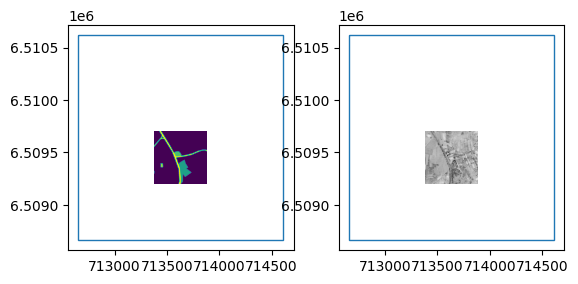

In [8]:
ds = Semcity(
    image_path,
    tile,
    crop_size,
    mins,
    maxs,
    img_aug=None,
    label_path=None,
    fixed_crops=False,
    crop_step=None,
    labels='base',
    bands=[3,2,1]
)

item = ds[0]
print(item['image'][0].shape)

fig2, (ax2, ax3) = plt.subplots(1, 2)
f, e = shape_color("C0", 0)
zone_patch = plotting.patch_from_polygon(zone, facecolor=f, edgecolor=e)
ax2.add_patch(copy(zone_patch))
ax3.add_patch(copy(zone_patch))
rioplt.show(item['label'].numpy(), ax=ax2, transform=item['tf_label'], cmap='viridis')
rioplt.show(item['image'][0].numpy(), ax=ax3, transform=item['tf_image'], cmap='gray')
ax2.autoscale_view()
ax3.autoscale_view()

In [22]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from dl_toolbox.torch_collate import CustomCollate

mask46 = shapely.geometry.MultiPolygon(mask46polys)
train_sets, test_sets = [], []
for i, zone in enumerate(intersections):
    dataset = PolyRaster(
        raster_img_path=img_path_46,
        raster_label_path=label_path_46,
        polygon=zone,
        crop_size=256,
        labels='base',
        raster_mask_poly=mask46
    )
    if i%5==0:
        test_sets.append(dataset)
    else:
        train_sets.append(dataset)
        
train_set = ConcatDataset(train_sets)
test_set = ConcatDataset(test_sets)

train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=8,
    collate_fn=CustomCollate(),
    sampler=RandomSampler(
        data_source=train_set,
        replacement=True,
        num_samples=2000
    ),
    num_workers=6,
    pin_memory=True,
    drop_last=True
)

val_dataloader = DataLoader(
    dataset=test_set,
    sampler=RandomSampler(
        data_source=test_set,
        replacement=True,
        num_samples=500
    ),
    collate_fn=CustomCollate(),
    batch_size=8,
    num_workers=6,
    pin_memory=True
)

In [23]:
class LabelsToRGB:
    # Inputs shape : B,H,W or H,W
    # Outputs shape : B,H,W,3 or H,W,3

    def __init__(self, labels):

        self.labels = labels

    def __call__(self, labels):
        rgb = np.zeros(shape=(*labels.shape, 3), dtype=np.uint8)
        for label, key in enumerate(self.labels):
            mask = np.array(labels == label)
            rgb[mask] = np.array(self.labels[key]['color'])

        return rgb

labels_to_rgb = LabelsToRGB(labels_dict['base'])

for i, batch in enumerate(train_dataloader):
    print(batch.keys())
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        imgs = batch['image']
        ax[0].imshow(batch['image'][j][0].numpy(), cmap='gray')
        ax[1].imshow(labels_to_rgb(batch['label'][j]))
        #ax[0].set_title(batch['path'][j])
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break


dict_keys(['image', 'label', 'crop', 'path'])


/tmp/ipykernel_7931/405870891.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [24]:
from dl_toolbox.lightning_modules import CE

module = CE(
    out_channels=9,
    ignore_zero=False,
    network='SmpUnet',
    encoder='efficientnet-b0',
    pretrained=False,
    weights=[],
    in_channels=1,
    initial_lr=0.001,
    final_lr=0.0005,
    plot_calib=False,
    ttas = ['vflip'],
    class_names=list(test_set.datasets[0].labels.keys()),
)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint#, DeviceStatsMonitor
from datetime import datetime

trainer = Trainer(
    max_steps=50000,
    accelerator='gpu',
    devices=1,
    limit_train_batches=1.,
    limit_val_batches=1.,
    logger=TensorBoardLogger(
        save_dir='/data/outputs/alumhi',
        name='test_alumhi',
        version=f'{datetime.now():%d%b%y-%Hh%Mm%S}'
    ),
    callbacks=[
        ModelCheckpoint(),
    ]
)
    
#ckpt_path='/data/outputs/test_bce_resisc/version_2/checkpoints/epoch=49-step=14049.ckpt'
trainer.fit(
    model=module,
    train_dataloaders={'sup': train_dataloader},
    val_dataloaders=val_dataloader,
    ckpt_path=None
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | SmpUnet          | 6.3 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.008    Total estimated model params size (MB)


Epoch 0:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 250/313 [00:21<00:05, 11.37it/s, loss=0.56, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 250/313 [00:22<00:05, 11.34it/s, loss=0.66, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 250/313 [00:22<00:05, 11.33it/s, loss=0.617, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 250/313 [00:22<00:05, 11.35it/s, loss=0.502, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|██████████████████████████████████████